In [2]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor

# 경로 설정
DATA_PATH = "../../data/raw/"
SUB_PATH = "./submissions/"

In [3]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed_everything(SEED)

In [4]:
# ============================================================
# 이상치/무응답 처리
# ============================================================
def clean_data(df):
    df = df.copy()
    
    # 무응답 (0 → NaN)
    for col in ['education', 'engnat', 'hand', 'married', 'urban']:
        if col in df.columns:
            df.loc[df[col] == 0, col] = np.nan
    
    # familysize
    if 'familysize' in df.columns:
        df.loc[df['familysize'] == 0, 'familysize'] = np.nan
        df.loc[df['familysize'] > 15, 'familysize'] = np.nan
    
    # TP 0 → NaN
    for col in [f"tp{i:02d}" for i in range(1, 11)]:
        if col in df.columns:
            df.loc[df[col] == 0, col] = np.nan
    
    # Q_E 클리핑
    for col in [f"Q{c}E" for c in "abcdefghijklmnopqrst"]:
        if col in df.columns:
            df[col] = df[col].clip(lower=100, upper=60000)
    
    return df


# ============================================================
# 피처 엔지니어링
# ============================================================
def build_features(df):
    df = df.copy()
    
    # 인구통계
    age_map = {"10s": 1, "20s": 2, "30s": 3, "40s": 4, "50s": 5, "60s": 6, "+70s": 7}
    df["age_ord"] = df["age_group"].map(age_map)
    df["is_teenager"] = (df["age_ord"] == 1).astype(int)
    df["is_young"] = (df["age_ord"] <= 2).astype(int)
    df["is_old"] = (df["age_ord"] >= 6).astype(int)
    df["edu_low"] = (df["education"] <= 2).astype(float)
    df["edu_high"] = (df["education"] >= 3).astype(float)
    df["is_single"] = (df["married"] == 1).astype(float)
    df["is_married"] = (df["married"] == 2).astype(float)
    df["is_urban"] = (df["urban"] == 3).astype(float)
    df["is_english_native"] = (df["engnat"] == 1).astype(float)
    df["is_male"] = (df["gender"] == "Male").astype(int)
    
    # Q_A 집계
    qa_cols = [f"Q{c}A" for c in "abcdefghijklmnopqrst"]
    df["qa_mean"] = df[qa_cols].mean(axis=1)
    df["qa_std"] = df[qa_cols].std(axis=1)
    df["qa_range"] = df[qa_cols].max(axis=1) - df[qa_cols].min(axis=1)
    df["qa_extreme_ratio"] = ((df[qa_cols] == 1) | (df[qa_cols] == 5)).sum(axis=1) / 20
    df["qa_neutral_ratio"] = (df[qa_cols] == 3).sum(axis=1) / 20
    df["qa_all_same"] = (df[qa_cols].std(axis=1) == 0).astype(int)
    
    # Q_E 로그 + 집계
    qe_cols = [f"Q{c}E" for c in "abcdefghijklmnopqrst"]
    for col in qe_cols:
        df[f"{col}_log"] = np.log1p(df[col])
    
    qe_log_cols = [f"{col}_log" for col in qe_cols]
    df["qe_log_mean"] = df[qe_log_cols].mean(axis=1)
    df["qe_log_std"] = df[qe_log_cols].std(axis=1)
    df["qe_fast_ratio"] = (df[qe_cols] < 500).sum(axis=1) / 20
    df["qe_total_log"] = df[qe_log_cols].sum(axis=1)
    df["is_careless"] = ((df[qe_cols].mean(axis=1) < 500) | (df["qa_all_same"] == 1)).astype(int)
    
    # TP Big5
    tp_cols = [f"tp{i:02d}" for i in range(1, 11)]
    df["tp_missing_ratio"] = df[tp_cols].isna().sum(axis=1) / 10
    df["extraversion"] = df["tp01"] - df["tp06"]
    df["agreeableness"] = df["tp07"] - df["tp02"]
    df["conscientiousness"] = df["tp03"] - df["tp08"]
    df["neuroticism"] = df["tp04"] - df["tp09"]
    df["openness"] = df["tp05"] - df["tp10"]
    df["tp_mean"] = df[tp_cols].mean(axis=1)
    
    # WR/WF
    wr_cols = [f"wr_{i:02d}" for i in range(1, 14)]
    wf_cols = [f"wf_{i:02d}" for i in range(1, 4)]
    df["wr_sum"] = df[wr_cols].sum(axis=1)
    df["wf_sum"] = df[wf_cols].sum(axis=1)
    df["word_credibility"] = df["wr_sum"] - df["wf_sum"]
    df["vocab_high"] = (df["wr_sum"] >= 11).astype(int)
    
    # Interaction
    df["age_edu"] = df["age_ord"] * df["education"]
    df["young_low_edu"] = df["is_young"] * df["edu_low"]
    df["young_single"] = df["is_young"] * df["is_single"]
    df["old_married"] = df["is_old"] * df["is_married"]
    df["teenager_low_edu"] = df["is_teenager"] * df["edu_low"]
    
    return df

# ============================================================
# 피처 정의
# ============================================================
qa_cols = [f"Q{c}A" for c in "abcdefghijklmnopqrst"]
qe_log_cols = [f"Q{c}E_log" for c in "abcdefghijklmnopqrst"]
wr_cols = [f"wr_{i:02d}" for i in range(1, 14)]
wf_cols = [f"wf_{i:02d}" for i in range(1, 4)]
tp_cols = [f"tp{i:02d}" for i in range(1, 11)]

num_features = (
    qa_cols + qe_log_cols + wr_cols + wf_cols + tp_cols +
    [
        "age_ord", "education", "married", "urban", "engnat", "familysize", "hand",
        "is_teenager", "is_young", "is_old", "edu_low", "edu_high",
        "is_single", "is_married", "is_urban", "is_english_native", "is_male",
        "qa_mean", "qa_std", "qa_range", "qa_extreme_ratio", "qa_neutral_ratio", "qa_all_same",
        "qe_log_mean", "qe_log_std", "qe_fast_ratio", "qe_total_log", "is_careless",
        "tp_missing_ratio", "tp_mean",
        "extraversion", "agreeableness", "conscientiousness", "neuroticism", "openness",
        "wr_sum", "wf_sum", "word_credibility", "vocab_high",
        "age_edu", "young_low_edu", "young_single", "old_married", "teenager_low_edu",
    ]
)

te_features = ['age_group_te', 'race_te', 'religion_te', 
               'age_edu_cat_te', 'age_married_cat_te', 'age_race_cat_te', 'age_edu_married_cat_te']

cat_features = ['gender', 'race', 'religion']

print(f"📊 피처: num={len(num_features)}, te={len(te_features)}, cat={len(cat_features)}")

📊 피처: num=110, te=7, cat=3


In [5]:
# 1. 데이터 로드
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test = pd.read_csv(os.path.join(DATA_PATH, "test_x.csv"))
submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))

# 2. 전처리 및 피처 엔지니어링 (제공해주신 함수 활용)
train = clean_data(train)
test = clean_data(test)

train = build_features(train)
test = build_features(test)

# 타겟 변수 변환: 2(투표안함)를 1로, 1(투표함)을 0으로 변환 (AUC 0.8 타겟팅)
train['voted'] = (train['voted'] == 2).astype(int)

In [12]:
# 3. AutoGluon 전용 딥러닝 하이퍼파라미터 설정
deep_learning_hyperparameters = {
    # 1. NN_TORCH: 다양한 구조의 파이토치 신경망
    'NN_TORCH': [
        {'num_epochs': 100, 'learning_rate': 0.001, 'num_layers': 3, 'hidden_size': 128, 'ag_args': {'name_suffix': '_Standard'}},
        {'num_epochs': 150, 'learning_rate': 0.0005, 'num_layers': 5, 'hidden_size': 256, 'dropout_prob': 0.4, 'ag_args': {'name_suffix': '_Deep'}},
        {'num_epochs': 200, 'learning_rate': 0.0001, 'num_layers': 2, 'hidden_size': 512, 'ag_args': {'name_suffix': '_Wide'}}
    ],
    # 2. FASTAI: Fast.ai 기반의 신경망 (딥러닝)
    'FASTAI': [
        {'epochs': 50, 'lr': 0.01, 'layers': [200, 100]}, # 기본적인 딥러닝 구조
    ]
}

predictor = TabularPredictor(
    label='voted',
    eval_metric='roc_auc',
    path="autogluon_deep_only"
).fit(
    train_data=train,
    hyperparameters=deep_learning_hyperparameters,
    presets='high_quality',
    num_bag_folds=5,            # 메모리 4.4GB 고려
    num_stack_levels=1,
    dynamic_stacking=False,
    # 머신러닝 모델이 실수로라도 껴 들어오지 않도록 명시적 차단
    included_model_types=['NN_TORCH', 'FASTAI'], 
    ag_args_fit={'num_gpus': 0} # Mac은 CPU/MPS를 쓰므로 0으로 설정
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Thu Sep 12 23:35:29 PDT 2024; root:xnu-10063.141.1.701.1~1/RELEASE_ARM64_T6000
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       4.25 GB / 16.00 GB (26.6%)
Disk Space Avail:   364.72 GB / 460.43 GB (79.2%)
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~5x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
Beginning A


[ 모델별 성능 리더보드 ]


,model,score_val,pred_time_val,fit_time,stack_level
0,WeightedEnsemble_L3,0.769152,2.875420,173.180586,3
1,WeightedEnsemble_L2,0.768934,1.953675,131.243513,2
2,NeuralNetTorch_Deep_BAG_L1,0.766376,0.542378,46.704489,1
3,NeuralNetTorch_Standard_BAG_L2,0.766331,2.451186,146.895891,2
4,NeuralNetTorch_Deep_BAG_L2,0.766060,2.479978,172.225033,2
5,NeuralNetTorch_Standard_BAG_L1,0.766015,0.466381,16.231807,1
6,NeuralNetTorch_Wide_BAG_L1,0.764889,0.573640,43.073316,1
7,NeuralNetTorch_Wide_BAG_L2,0.763307,2.503731,169.195174,2
8,NeuralNetFastAI_BAG_L2,0.757889,2.366266,155.814318,2
9,NeuralNetFastAI_BAG_L1,0.755376,0.365457,24.637429,1


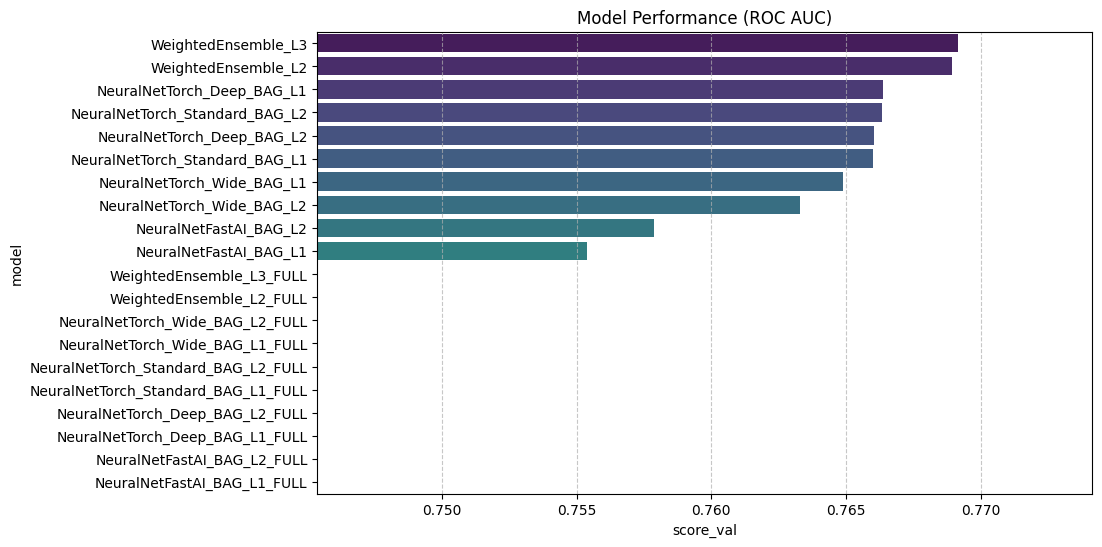

These features in provided data are not utilized by the predictor and will be ignored: ['is_male']
Computing feature importance via permutation shuffling for 134 features using 1000 rows with 5 shuffle sets...



[ 피처 중요도 계산 중... ]


	89.06s	= Expected runtime (17.81s per shuffle set)
	44.27s	= Actual runtime (Completed 5 of 5 shuffle sets)


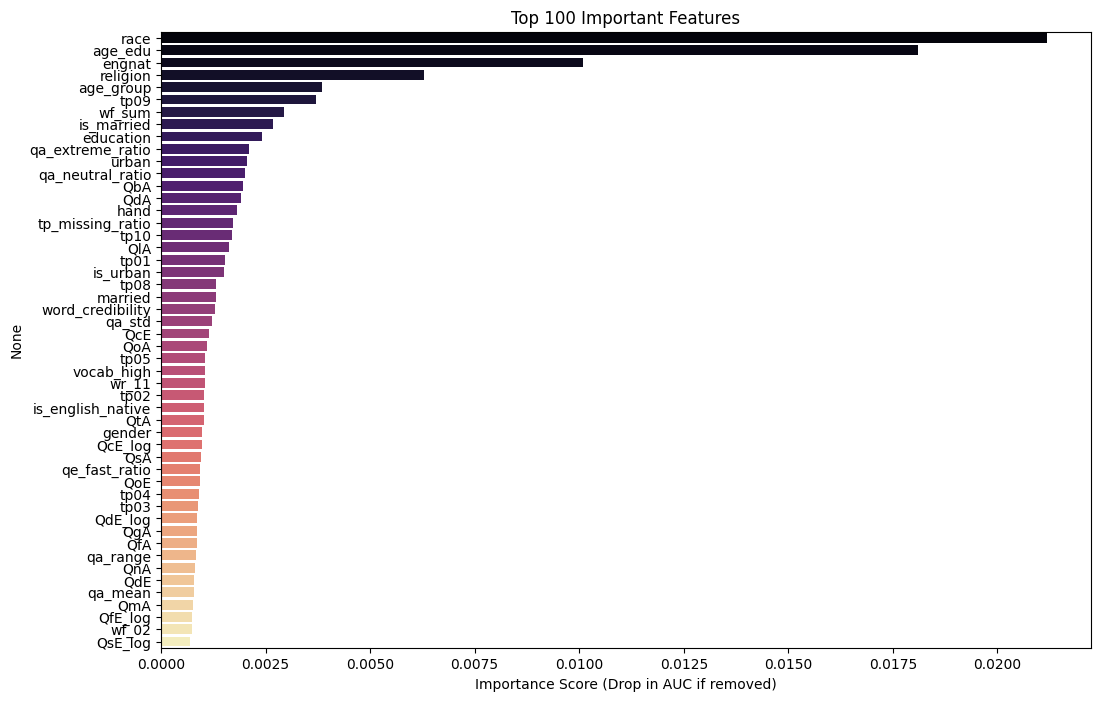


[ 앙상블 모델 내 개별 모델 가중치 ]
- NeuralNetFastAI_BAG_L1: 0.1600
- NeuralNetTorch_Standard_BAG_L1: 0.4000
- NeuralNetTorch_Deep_BAG_L1: 0.3200
- NeuralNetTorch_Wide_BAG_L1: 0.1200


In [13]:
# ------------------------------------------------------------
# 5. 모델 성능 리더보드 시각화
# ------------------------------------------------------------
# 리더보드 가져오기
lb = predictor.leaderboard(extra_info=True)
print("\n[ 모델별 성능 리더보드 ]")
display(lb[['model', 'score_val', 'pred_time_val', 'fit_time', 'stack_level']])

# 리더보드 시각화 (AUC 점수 기준)
plt.figure(figsize=(10, 6))
sns.barplot(data=lb.sort_values(by='score_val', ascending=False), x='score_val', y='model', palette='viridis')
plt.title('Model Performance (ROC AUC)')
plt.xlim(lb['score_val'].min() - 0.01, lb['score_val'].max() + 0.005)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ------------------------------------------------------------
# 6. 피처 중요도 (Feature Importance) 확인
# ------------------------------------------------------------
# 주의: 피처 중요도 계산은 모델에 따라 시간이 다소 소요될 수 있습니다.
print("\n[ 피처 중요도 계산 중... ]")
# 앙상블 모델 전체에 대한 중요도를 계산 (샘플링을 통해 속도 조절 가능)
fi = predictor.feature_importance(train.sample(n=1000, random_state=SEED))

# 상위 100개 피처 시각화
plt.figure(figsize=(12, 8))
top_fi = fi.head(50)
sns.barplot(x='importance', y=top_fi.index, data=top_fi, palette='magma')
plt.title('Top 100 Important Features')
plt.xlabel('Importance Score (Drop in AUC if removed)')
plt.show()

# ------------------------------------------------------------
# 7. 앙상블 가중치 확인 (Weighted Ensembler가 어떤 모델을 선호했는가)
# ------------------------------------------------------------
model_names = predictor.model_names()
# WeightedEnsemble 모델 이름 찾기 (보통 마지막에 위치)
ensemble_model = [m for m in model_names if 'WeightedEnsemble' in m][0]
weights = predictor.info()['model_info'][ensemble_model]['children_info']['S1F1']['model_weights']

print("\n[ 앙상블 모델 내 개별 모델 가중치 ]")
for model, weight in weights.items():
    print(f"- {model}: {weight:.4f}")

In [14]:
# 5. 결과 확인
leaderboard = predictor.leaderboard()
print(leaderboard)

                                  model  score_val eval_metric  pred_time_val  \
0                   WeightedEnsemble_L3   0.769152     roc_auc       2.875420   
1                   WeightedEnsemble_L2   0.768934     roc_auc       1.953675   
2            NeuralNetTorch_Deep_BAG_L1   0.766376     roc_auc       0.542378   
3        NeuralNetTorch_Standard_BAG_L2   0.766331     roc_auc       2.451186   
4            NeuralNetTorch_Deep_BAG_L2   0.766060     roc_auc       2.479978   
5        NeuralNetTorch_Standard_BAG_L1   0.766015     roc_auc       0.466381   
6            NeuralNetTorch_Wide_BAG_L1   0.764889     roc_auc       0.573640   
7            NeuralNetTorch_Wide_BAG_L2   0.763307     roc_auc       2.503731   
8                NeuralNetFastAI_BAG_L2   0.757889     roc_auc       2.366266   
9                NeuralNetFastAI_BAG_L1   0.755376     roc_auc       0.365457   
10             WeightedEnsemble_L3_FULL        NaN     roc_auc            NaN   
11             WeightedEnsem

In [ ]:
pred_probs = predictor.predict_proba(test)
submission = pd.read_csv("../../data/raw/sample_submission.csv")
submission['voted'] = pred_probs[1]

submission.to_csv("./submissions/autogluon_final_submission.csv", index=False)